Efficiency Toy
====

Example of the efficiency correction procedure using multiple distributions

In [1]:
# Just some boilerplate code
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from tqdm import tqdm

from matplotlib import rcParams

rcParams["figure.figsize"] = (10.0, 8.0)

rng = np.random.default_rng()
pdf_domain = (-3, 3)
pdf_range = (0, 1.0)


def sample(N, pdf):
    """
    Use accept-reject sampling to get N samples from pdf
    
    slow
    """
    
    points = np.zeros(N)
    num_generated = 0
    
    with tqdm(total=N) as pbar:
        while num_generated < N:
            # Generate a point
            x = pdf_domain[0] + (pdf_domain[1] - pdf_domain[0]) * rng.random()
            y = pdf_range[0] + (pdf_range[1] - pdf_range[0]) * rng.random()

            if y < pdf(x):
                points[num_generated] = x
                num_generated += 1
                pbar.update(1)

    return points

We have three different distributions - call them WS, RS ("wrong/right sign") and phsp.
We can generate these from the models ("model sample") or via LHCb Monte Carlo ("MC sample").

The MC samples are affected by the efficiency- by comparing the MC sample to the model samples
we can extract the efficiency function $\epsilon(x)$.

We have three models; their PDFs are $\mathcal{A}_{RS}(x)$, $\mathcal{A}_{WS}(x)$ and $\mathcal{A}_{phsp}(x)$.
The corresponding PDFs describing the MC are $\mathcal{A}_{RS}(x)\epsilon(x)$, etc.

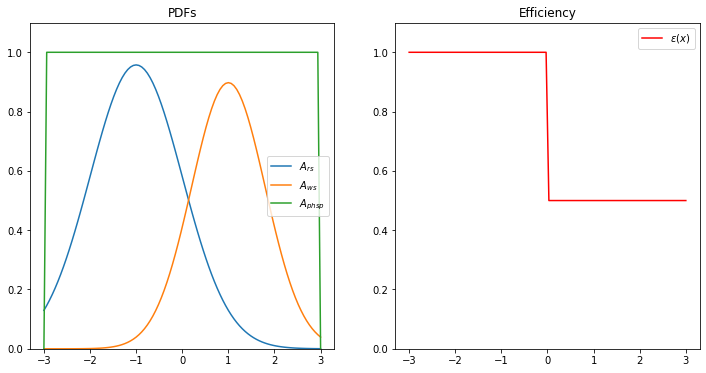

In [10]:
# Model "PDFs" - not normalised (on purpose, since in reality amplitude models are rarely normalised)
def A_rs(x):
    return 2.4 * norm.pdf(x, loc=-1.0, scale=1)

def A_ws(x):
    return 1.8 * norm.pdf(x, loc=1.0, scale=0.8)

def A_phsp(x):
    return int(pdf_domain[0] < x < pdf_domain[1])

def e(x):
    if x < 0.0:
        return 1
    return 0.5

x = np.linspace(*pdf_domain, 100)
fig, ax = plt.subplots(1, 2, figsize=(12.0, 6.0))
ax[0].plot(x, [A_rs(i) for i in x], label=r"$A_{rs}$")
ax[0].plot(x, [A_ws(i) for i in x], label=r"$A_{ws}$")
ax[0].plot(x, [A_phsp(i) for i in x], label=r"$A_{phsp}$")
ax[0].set_ylim((0.0, 1.1))
ax[0].legend()
ax[0].set_title("PDFs")

ax[1].plot(x, [e(i) for i in x], label="$\epsilon(x)$", color="r")
ax[1].legend()
ax[1].set_ylim((0.0, 1.1))
ax[1].set_title("Efficiency")

plt.show()


We can describe the combined RS + phsp samples with the following PDF:
$p_{model}(x) = \mathcal{I}_{RS}\mathcal{A}_{RS}(x) + \mathcal{I}_{phsp}\mathcal{A}_{phsp}(x)$, where the $\mathcal{I}$ coefficients are found from:

$\mathcal{I}_{j} = \sum_{x_i \epsilon \{x_j\}}1/p_j(x_i)$  
i.e.; the RS coefficient is found from the sum of the inverse RS probabilities over the RS dataset.

The PDF describing the combined RS + WS + phsp model samples is then:

$p(x) = \mathcal{I}_{model}p_{model}(x) + \mathcal{I}_{WS}\mathcal{A}_{WS}(x)$

the PDF describing the combined MC samples is this multiplied by $\epsilon(x)$.

Below is a toy example of the procedure used to find the efficiency.

First we need to generate MC samples:

In [11]:
# Generate different numbers of points from each distribution 
N_rs, N_ws, N_phsp = 20000, 20000, 2000

mc_rs_sample = sample(N_rs, lambda x: A_rs(x) * e(x))
mc_ws_sample = sample(N_ws, lambda x: A_ws(x) * e(x))
mc_phsp_sample = sample(N_phsp, lambda x: A_phsp(x) * e(x))

mc_sample = np.concatenate((mc_rs_sample, mc_ws_sample, mc_phsp_sample))

100%|██████████| 2000/2000 [00:00<00:00, 340917.17it/s]


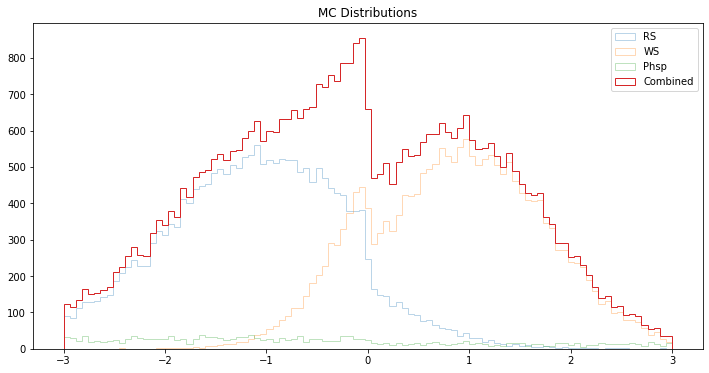

In [12]:
bins = x
kw = {"histtype": "step", "bins": bins}

plt.figure(figsize=(12.0, 6.0))
plt.hist(mc_rs_sample, **kw, alpha=0.3, label="RS")
plt.hist(mc_ws_sample, **kw, alpha=0.3, label="WS")
plt.hist(mc_phsp_sample, **kw, alpha=0.3, label="Phsp")
plt.hist(mc_sample, **kw, label="Combined")
plt.legend()
plt.title("MC Distributions")
plt.show()

Next we need to find the weights $\mathcal{I}_i$ describing the combined model:

In [13]:
I_rs, I_phsp = 0.0, 0.0

for p in mc_rs_sample:
    I_rs += 1 / A_rs(p)
for p in mc_ws_sample:  # ws here
    I_phsp += 1 / A_ws(p)
    
# Scale the weights to something more sensible
scale_factor = I_rs + I_phsp
I_rs /= scale_factor
I_phsp /= scale_factor

def p_rs_phsp(x):
    return I_rs * A_rs(x) + I_phsp * A_ws(x)  # ws here

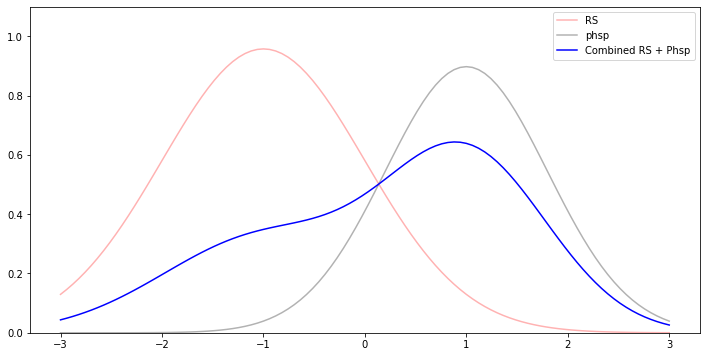

In [14]:
plt.figure(figsize=(12.0, 6.0))
plt.plot(x, [A_rs(i) for i in x], "r", label="RS", alpha=0.3)
plt.plot(x, [A_ws(i) for i in x], "k", label="phsp", alpha=0.3)

plt.plot(x, [p_rs_phsp(i) for i in x], "b", label="Combined RS + Phsp")
plt.gca().set_ylim((0.0, 1.1))
plt.legend()

plt.show()

Let's take a sample from the RS+Phsp PDF (blue curve) and see if we can recover the correct efficiency from it:

In [15]:
rs_phsp_sample = sample(N_rs + N_ws, p_rs_phsp)  # ws here

100%|██████████| 40000/40000 [00:22<00:00, 1782.60it/s]


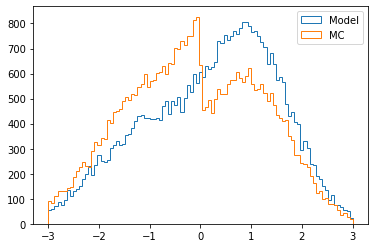

In [16]:
combined_rs_phsp = np.concatenate((mc_rs_sample, mc_ws_sample))
plt.hist(rs_phsp_sample, **kw, label="Model")
plt.hist(combined_rs_phsp, **kw, label="MC")
plt.legend()
plt.show()

Let's take the ratio to find the efficiency.

We want to scale the efficiency to have the right mean value

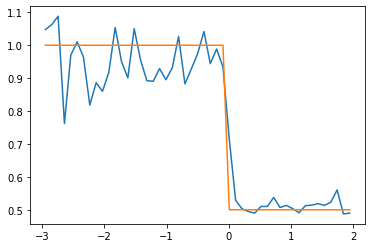

In [19]:
def scaled_efficiency(model, mc, bins, avg_efficiency):
    """
    Bin two datasets, take the ratio of the resulting histograms then scale the ratio to have the desired average
    
    """   
    mc_hist, _ = np.histogram(mc, bins)
    model_hist, _ = np.histogram(model, bins)
    
    hist_ratio = mc_hist / model_hist
    
    scale_factor = avg_efficiency / np.mean(hist_ratio)
    
    return hist_ratio * scale_factor
   
def centres(bins):
    return (bins[1:] + bins[:-1]) / 2
    
def ideal_efficiency(bins):
    return [e(x) for x in centres(bins)]

x = np.linspace(-3, 2)
measured = scaled_efficiency(rs_phsp_sample, combined_rs_phsp, x, 0.775)
actual = ideal_efficiency(x)

plt.plot(centres(x), measured)
plt.plot(centres(x), actual)
plt.show()

We can now try doing this with three distributions.

Posit that adding a third PDF to our combined PDF should just look like the above

$p_{all} = I_{WS}p_{WS} + I_2p_2$

In [ ]:
I_2, I_WS = 0.0, 0.0

for p in combined_rs_phsp:
    I_2 += 1 / p_rs_phsp(p)
for p in mc_ws_sample:
    I_WS += 1 / A_ws(p)
    
# Scale the weights to something more sensible
scale_factor = I_2 + I_WS
I_2 /= scale_factor
I_WS /= scale_factor


In [ ]:
def p_combined(x):
    return I_2 * p_rs_phsp(x) + I_WS * A_ws(x)


plt.figure(figsize=(12.0, 6.0))
plt.plot(x, [A_ws(i) for i in x], "r", label="WS", alpha=0.3)
plt.plot(x, [p_rs_phsp(i) for i in x], "k", label="RS+phsp", alpha=0.3)

plt.plot(x, [p_combined(i) for i in x], "b", label="Combined")
plt.gca().set_ylim((0.0, 1.1))
plt.legend()

plt.show()

Now we just need to take a sample from the Model PDF, compare it to our combined MC samples and we should recover the correct efficiency.

In [ ]:
# Take a sample from the combined PDF
combined_sample = sample(N_rs + N_rs + N_phsp, p_combined)

In [ ]:
fig = plt.figure(figsize=(12.0, 6.0))

model_hist, _, _ = plt.hist(combined_sample, **kw, label="Model", color="b")
mc_hist, _, _ = plt.hist(mc_sample, **kw, label="MC", color="r")
plt.title("Samples")
plt.legend()

plt.show()

In [ ]:
measured = scaled_efficiency(combined_sample, mc_sample, x, 2. / 3.)

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(9, 6))

bin_centres = centres(x)
ax[0].plot(bin_centres, model_hist, "b", label="Model")
ax[0].plot(bin_centres, mc_hist, "r", label="MC")
ax[0].legend()


ax[1].plot(bin_centres, measured, "k+", label="Measured")
ax[1].plot(bin_centres, actual, label="Actual")
ax[1].set_title("Efficiency (normalised)")
ax[1].set_ylim((0.0, 1.5))
ax[1].legend()
plt.show()